In [1]:
pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from stockstats import*
import cv2
from PIL import Image

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler, MaxAbsScaler, PowerTransformer
from keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math

TIME_RANGE, PRICE_RANGE = 40, 40

Data Handling Methods



In [8]:
def scale_list(l, to_min, to_max):
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

In [9]:
def getState(data, sell_option, t, TIME_RANGE, PRICE_RANGE):
    closing_values = data[0]
    macd = data[1]
    macds = data[2]
    #print(closing_values)
    half_scale_size = int(PRICE_RANGE / 2)

    graph_closing_values = list(np.round(scale_list(closing_values[t - TIME_RANGE:t], 0, half_scale_size - 1), 0))
    macd_data_together = list(
        np.round(scale_list(list(macd[t - TIME_RANGE:t]) + list(macds[t - TIME_RANGE:t]), 0, half_scale_size - 1), 0))
    graph_macd = macd_data_together[0:PRICE_RANGE]
    graph_macds = macd_data_together[PRICE_RANGE:]

    blank_matrix_macd = np.zeros((half_scale_size, TIME_RANGE, 3), dtype=np.uint8)
    x_ind = 0
    for s, d in zip(graph_macds, graph_macd):
        blank_matrix_macd[int(s), x_ind] = (0, 0, 255)
        blank_matrix_macd[int(d), x_ind] = (255, 175,0)
        x_ind += 1
    blank_matrix_macd = blank_matrix_macd[::-1]

    blank_matrix_close = np.zeros((half_scale_size, TIME_RANGE, 3), dtype=np.uint8)
    x_ind = 0
    if sell_option == 1:
      close_color = (0, 255, 0) #GREEN
    else:
      close_color = (255,0 , 0) #RED

    for v in graph_closing_values:
        blank_matrix_close[int(v), x_ind] = close_color
        x_ind += 1
    blank_matrix_close = blank_matrix_close[::-1]

    blank_matrix = np.vstack([blank_matrix_close, blank_matrix_macd])

    if 2 == 2:
        # graphed on matrix
        plt.imshow(blank_matrix)
        plt.show()

    return [blank_matrix]


In [10]:
def getStockData(key):
    stock_data = df = pdr.get_data_tiingo(key, start = '8-14-2020', api_key='9d4f4dacda5024f00eb8056b19009f32e58b38e5')

    stats = StockDataFrame.retype(stock_data)
    stock_data['Symbol'] = key

    stock_dif = (stock_data['close'] - stock_data['open'])
    stock_dif = stock_dif.values



    
    noise_ma_smoother = 1
    macd = stats.get('macd')
    #stats.get('close_{}_ema'.format(noise_ma_smoother))
    macd = macd.fillna(method='bfill')  
    macd = list(macd.values)

    longer_ma_smoother = 7
    macds = stats.get('macds')
    #stats.get('close_{}_ema'.format(longer_ma_smoother))
    macds = macds.fillna(method='bfill')  
    macds =  list(macds.values)

  
    closing_values = list(np.array(stock_data['close']))

    return_data = [closing_values, macd, macds]

    return return_data


In [11]:

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def getBotPeformance(raw_data, window_size):
	#DATA is peformance data of bot, so : Total Profit made by bot in percent 
	#DATA = total_profit |  initial_profit *should only change if bot is selling
	raw_data = np.array(raw_data)
	data = (raw_data[0])/(abs(raw_data[1])) 
  #ADD more transformations later
	for i in range(data.shape[0]):
		if math.isnan(data[i]):
			data[i] = 0
		#data[i] = sigmoid(data[i])


	return_data = []
	if data.shape[0] >= window_size:
		return_data = data[-window_size:]
	else:
		d = (window_size - data.shape[0] + 1)
		return_data = np.concatenate((data[0:-1], d*[data[-1]]), axis=None)
	return return_data
def fix_input(state):
	state = np.array(state)
	img_rows, img_cols = TIME_RANGE, PRICE_RANGE
	state = np.reshape(state, (state.shape[0], img_rows, img_cols, 3))
	state = state.astype('float32')
	return state

			'''
		try:
			res[0].append((block[0][i + 1] - block[0][i])/block[0][i+1])
		except:
			res[0].append(block[0][i])
			'''

Agents

In [27]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class F_Bot:
	def __init__(self, window_size, model_name=""):
		self.model_name = model_name
		self.window_size = window_size
		self.forecast_model = self._model(self.window_size)
	def _model(self, window_size):
		forecast_model = Sequential()
		forecast_model.add(LSTM(128, return_sequences= True, input_shape = (window_size, 5)))
		forecast_model.add(LSTM(64, return_sequences= True))
		forecast_model.add(LSTM(64, return_sequences= False))
		forecast_model.add(Dense(units=1,  activation='linear'))
		forecast_model.compile(optimizer=Adam(learning_rate=.0001),loss='mean_squared_error')
		forecast_model.load_weights("StockBot/models/forecast/model_pi_1_5")
		return forecast_model

	def getForecastData(self, stocks):
		forecast = []
		window_size = self.window_size
		#Use F-Bot to calculate the n* forecasting values for the n* # of stocks
		number_stocks = len(stocks)
		for i in range(0, number_stocks):
			stock = stocks[i]
			df = pdr.get_data_tiingo(stock, start='8-14-2020', api_key='9d4f4dacda5024f00eb8056b19009f32e58b38e5') 
			data = df.filter(['close', 'open', 'high', 'low'])
			data = data[30:-1]
			dataset = data.values
			normalizer = Normalizer()
			scaler = RobustScaler()
			standard = MinMaxScaler(feature_range=(0,1)) 
			#normalizer = Normalizer()
			scaled_data = normalizer.fit_transform(dataset)
			scaled_data = scaler.fit_transform(scaled_data)
			scaled_data = standard.fit_transform(scaled_data)

		#VOLUME DATA

			v_data = df.filter(['volume'])
			v_data = v_data[30:-1].values
			volume_data = []
			for i in range(len(dataset)- 1):
				volume_data.append(v_data[i + 1] - v_data[i])

			s = MinMaxScaler(feature_range=(-1, 1))

			volume_data = np.array(volume_data)
			volume_data = np.reshape(volume_data, (volume_data.shape[0], 1))

			scaled_volume = s.fit_transform(volume_data)

			scaled_volume = np.reshape(scaled_volume, (1, scaled_volume.shape[0]))

			volume_vals = scaled_volume[0].tolist()

			volume_vals = np.array(volume_vals)

			#------------------------------------------------------------#


			train_data = scaled_data[0:-1, : ]

			x_vals = [[], [], [], [], []]

			for i in range(window_size, len(train_data) - 1):
				for j in range(0, train_data.shape[1] + 1):
					if j <= train_data.shape[1] - 1:
						x_vals[j].append(train_data[i - window_size: i, j])
					else:
						x_vals[j].append(volume_vals[i - window_size: i])
			x_vals= np.array(x_vals)

			x_vals = np.reshape(x_vals, (x_vals.shape[1], x_vals.shape[2], x_vals.shape[0]))
			predictions = self.forecast_model.predict(x_vals)
			predictions = np.array(predictions)
			predictions = np.reshape(predictions, (predictions.shape[1], predictions.shape[0]))
			#print(predictions[0])
			forecast.append(predictions[0])
		return forecast


Main Stock Bot Agent


In [28]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, PRICE_RANGE, TIME_RANGE, is_eval=False, model_name=""):
		self.price_range = PRICE_RANGE
		self.time_range = TIME_RANGE

		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=500_000)
		self.inventory = 0
		self.model_name = model_name
		self.is_eval = is_eval
		self.total_inventory = []

		self.gamma = 0.94
		self.epsilon = 0.8
		self.epsilon_min = 0.001
		self.epsilon_decay = 0.9988
		
		if is_eval:
			self.model = load_model(model_name)
		else:
			self.model = self.create_model()
		#self.model = load_model('/content/drive/MyDrive/StockBot/models/stock_bot_comp/New/model_4/model_4_1_22')

	def create_model(self):
			input_shape_1 = (self.time_range, self.price_range, 3)

			base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=input_shape_1)

			x = base_model.output
			x = GlobalAveragePooling2D()(x)

			predictions = Dense(self.action_size, activation='linear')(x)

			model = Model(inputs = base_model.inputs, outputs = predictions)

			model.compile(loss='mse', optimizer=Adam(learning_rate=.0001), metrics = ['accuracy'])
			return model

	def act(self, state):
		if not self.is_eval and random.random() <= self.epsilon:
			return random.randrange(self.action_size)
		options = self.model.predict(fix_input(state))
		print(options)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])
	#	mini_batch = random.sample(self.memory, batch_size)

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			state = fix_input(state)
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(fix_input(next_state))[0])
	
			target_f = self.model.predict(state)
			target_f[0][action] = target

			self.model.fit(state, target_f, epochs=1, verbose=0)
		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay


In [29]:
stocks = ['PLUG']
forecast_window = 60
f_bot = F_Bot(forecast_window)
forecast = f_bot.getForecastData(stocks)
print(len(forecast[0]))
forecast


175


[array([ 0.00817892,  0.04469377, -0.1275786 ,  0.28337777,  0.33131287,
         0.08122804,  0.20374046,  0.02276006, -0.02356809, -0.00304218,
         0.29832166, -0.5416534 ,  0.34308714, -0.29447076, -0.14817454,
         0.03084045,  0.27644002,  0.21847099, -0.24232523, -0.03081926,
         0.01347397, -0.14426413,  0.335338  , -0.01485124,  0.14436747,
         0.42258945,  0.11337683,  0.23734027, -0.00191227,  0.03388824,
        -0.33581012, -0.2550951 , -0.08765744,  0.39231884,  0.16596346,
         0.75133395, -0.24188133, -0.02371936,  0.0414234 ,  0.05887082,
         0.0532047 , -0.09573556, -0.19079055, -0.166148  , -0.2154181 ,
         0.0645524 ,  0.16506344,  0.17352536, -0.33432606, -0.44325954,
        -0.9181456 , -0.5954899 , -0.03751731, -0.5009773 ,  0.66729844,
         0.85451216, -0.18886934,  0.41106617,  0.82364637,  0.24235652,
         0.39697272,  0.40940616,  0.31350535, -0.0903665 ,  0.03358018,
        -0.34082884, -0.77372235, -0.2124833 , -0.3

Main Reinforcement Learning Code - Training

Episode 0/100


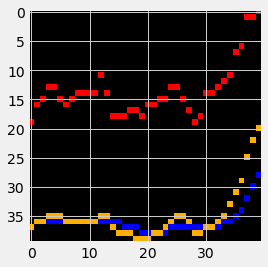

[[-1.4656864  2.1666672 -1.8673598]]


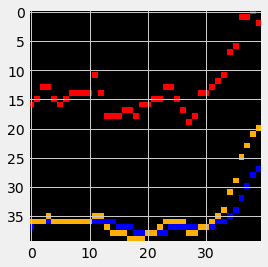

Close = 17.64 Money = 0,  Inventory = 0
Buy: 17.64 Amount : 5668
Reward : 5000


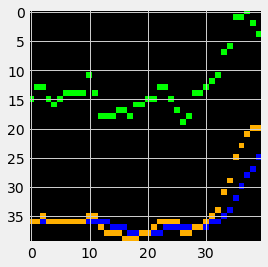

Close = 17.1 Money = 0,  Inventory = 5668
Sell: 17.1 Amount : 5668 | Profit: -3060.720000000001 | Equity : 96939.28
Reward : -3060.720000000001


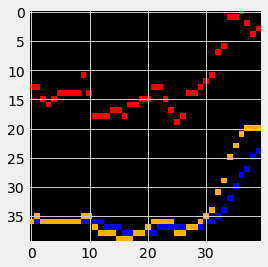

Close = 17.3 Money = -3060.720000000001,  Inventory = 0
Hold due to circumstances 2
Reward : -10000


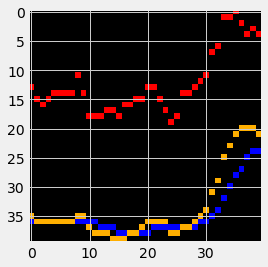

Close = 17.03 Money = -3060.720000000001,  Inventory = 0
Hold
Reward : 0


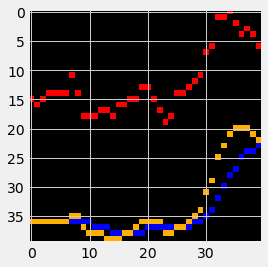

Close = 16.27 Money = -3060.720000000001,  Inventory = 0
Hold
Reward : 0
[[-1.2357628  1.9422979 -1.8662372]]


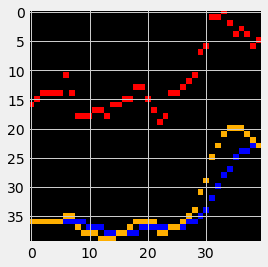

Close = 16.39 Money = -3060.720000000001,  Inventory = 0
Buy: 16.39 Amount : 5914
Reward : 5000


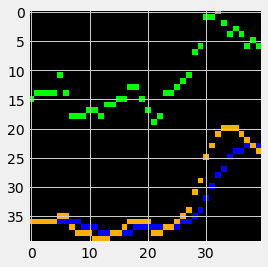

Close = 16.285 Money = -3060.720000000001,  Inventory = 5914
Hold
Reward : 0


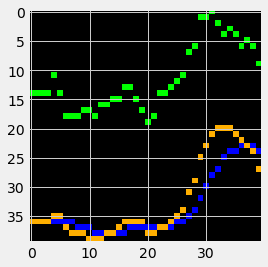

Close = 14.86 Money = -3060.720000000001,  Inventory = 5914
Hold
Reward : 0


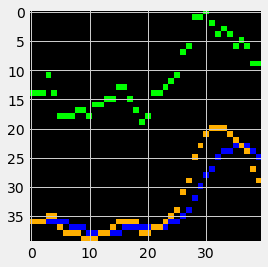

Close = 14.96 Money = -3060.720000000001,  Inventory = 5914
Sell: 14.96 Amount : 5914 | Profit: -8457.020000000004 | Equity : 88482.26
Reward : -8457.020000000004
[[-1.7604659  1.1652759 -2.471686 ]]


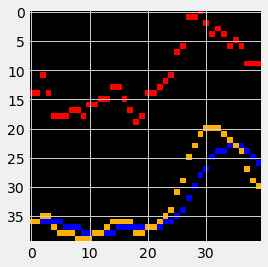

Close = 15.03 Money = -11517.740000000005,  Inventory = 0
Buy: 15.03 Amount : 5887
Reward : 5000


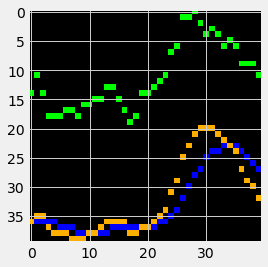

Close = 14.455 Money = -11517.740000000005,  Inventory = 5887
Sell: 14.455 Amount : 5887 | Profit: -3385.024999999994 | Equity : 85097.235
Reward : -3385.024999999994
[[-1.281058   2.2709033 -2.359893 ]]


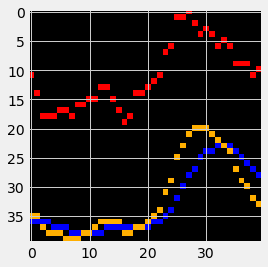

Close = 14.785 Money = -14902.765,  Inventory = 0
Buy: 14.785 Amount : 5755
Reward : 5000


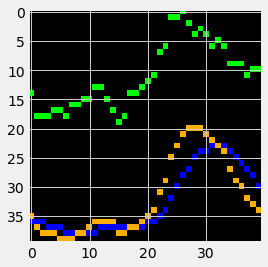

Close = 14.8 Money = -14902.765,  Inventory = 5755
Hold
Reward : 0
[[-1.2695937  2.298292  -2.6368794]]


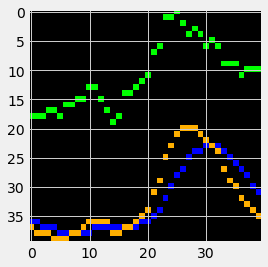

Close = 14.81 Money = -14902.765,  Inventory = 5755
Hold due to circumstances 1
Reward : -10000


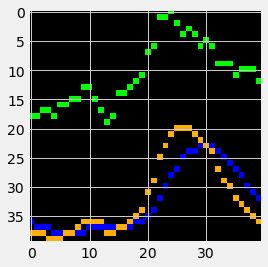

Close = 14.0 Money = -14902.765,  Inventory = 5755
Sell: 14.0 Amount : 5755 | Profit: -4517.675000000003 | Equity : 80579.56
Reward : -4517.675000000003


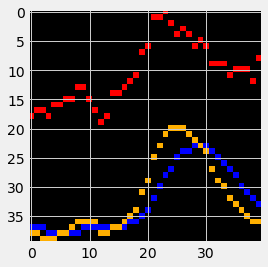

Close = 15.47 Money = -19420.440000000002,  Inventory = 0
Hold
Reward : 0


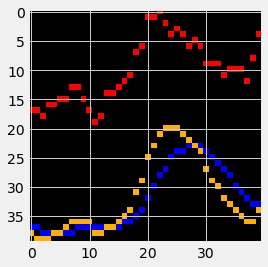

Close = 16.95 Money = -19420.440000000002,  Inventory = 0
Hold
Reward : 0


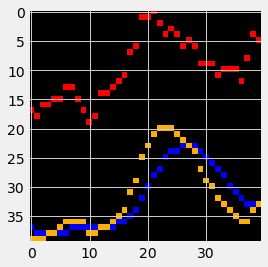

Close = 16.61 Money = -19420.440000000002,  Inventory = 0
Hold due to circumstances 2
Reward : -10000


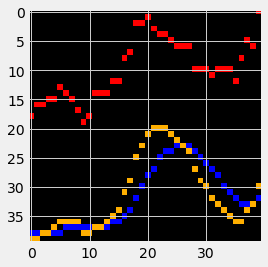

Close = 18.835 Money = -19420.440000000002,  Inventory = 0
Buy: 18.835 Amount : 4278
Reward : 5000


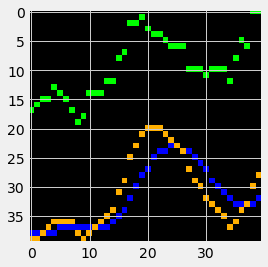

Close = 18.86 Money = -19420.440000000002,  Inventory = 4278
Hold
Reward : 0


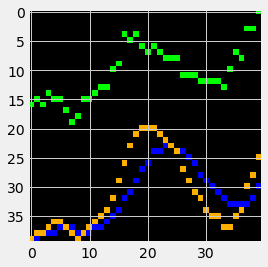

Close = 20.31 Money = -19420.440000000002,  Inventory = 4278
Sell: 20.31 Amount : 4278 | Profit: 6310.049999999988 | Equity : 86889.60999999999
Reward : 5777.52679663427


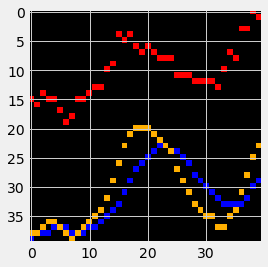

Close = 20.01 Money = -13110.390000000014,  Inventory = 0
Hold due to circumstances 2
Reward : -10000
[[-1.3670063  1.684781  -1.1062447]]


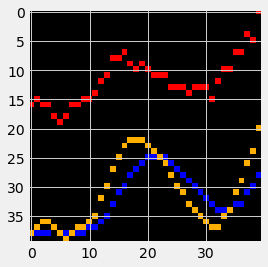

Close = 23.0 Money = -13110.390000000014,  Inventory = 0
Buy: 23.0 Amount : 3777
Reward : 5000
[[-0.47022    2.4050312 -2.451932 ]]


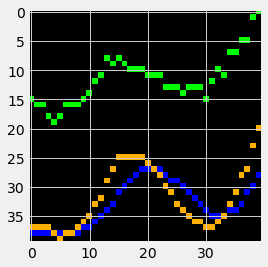

Close = 23.45 Money = -13110.390000000014,  Inventory = 3777
Hold due to circumstances 1
Reward : -10000


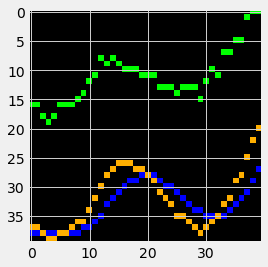

Close = 23.43 Money = -13110.390000000014,  Inventory = 3777
Hold due to circumstances 1
Reward : -10000


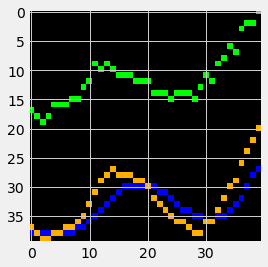

Close = 25.0 Money = -13110.390000000014,  Inventory = 3777
Sell: 25.0 Amount : 3777 | Profit: 7554.0 | Equity : 94443.60999999999
Reward : 7727.668013241168


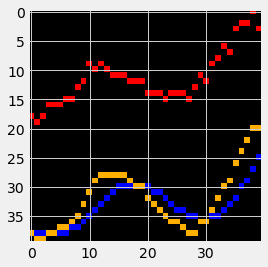

Close = 22.98 Money = -5556.390000000014,  Inventory = 0
Hold due to circumstances 2
Reward : -10000


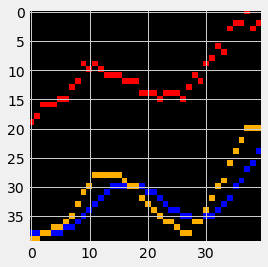

Close = 23.22 Money = -5556.390000000014,  Inventory = 0
Buy: 23.22 Amount : 4067
Reward : 5000


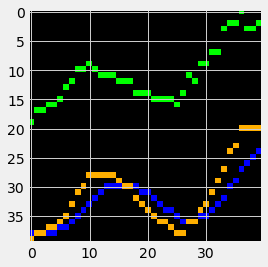

Close = 23.79 Money = -5556.390000000014,  Inventory = 4067
Hold due to circumstances 1
Reward : -10000
[[-0.857411   2.0408285 -2.522592 ]]


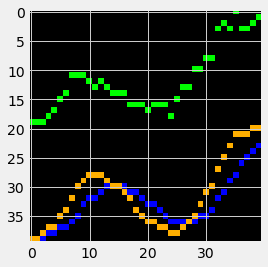

Close = 24.36 Money = -5556.390000000014,  Inventory = 4067
Hold due to circumstances 1
Reward : -10000


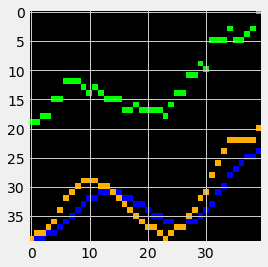

Close = 26.87 Money = -5556.390000000014,  Inventory = 4067
Sell: 26.87 Amount : 4067 | Profit: 14844.550000000017 | Equity : 109288.16
Reward : 18637.704669018924


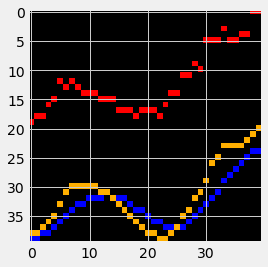

Close = 26.72 Money = 9288.160000000003,  Inventory = 0
Hold
Reward : 0


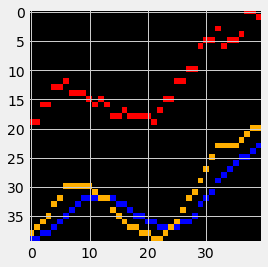

Close = 26.16 Money = 9288.160000000003,  Inventory = 0
Hold due to circumstances 2
Reward : -10000
REPLAY 0.7990400000000001


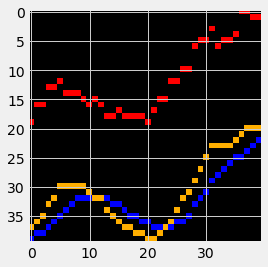

Close = 26.24 Money = 9288.160000000003,  Inventory = 0
Hold due to circumstances 2
Reward : -10000
REPLAY 0.7980811520000001


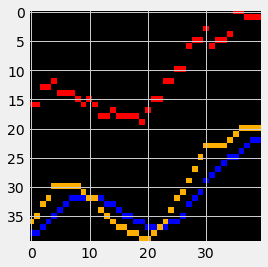

Close = 26.39 Money = 9288.160000000003,  Inventory = 0
Hold
Reward : 0


KeyboardInterrupt: 

In [30]:
import sys
import math
np.seterr(divide='ignore', invalid='ignore')

memory_count = 0

stock_name, episode_count = "PLUG",  100
agent = Agent(TIME_RANGE, PRICE_RANGE)
data = getStockData(stock_name)
close_values = data[0]

l = len(close_values)
agent.total_inventory.append(0)

for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    total_profit = 0
    initial_profit = 0
    agent.inventory = 0
    batch_size = 32 
    equity = 100_000
    initial_equity = 0
    change_equity = 0
    buy = 1
    sell = 1
    sell_option = 0

    profit_data = [[0], [equity]]
    state = getState(data, sell_option, TIME_RANGE, TIME_RANGE, PRICE_RANGE)
    count = 1

    for t in range(TIME_RANGE, l):
        
        action = agent.act(state)

        # sit
        next_state = getState(data, sell_option, t + 1, TIME_RANGE, PRICE_RANGE)
        #print(next_state)
        reward = 0
        close = data[0][t]
        

        buy = math.floor(equity / close)
        sell = agent.inventory
        #print("Close = {}  :   Open = {}  :  Volume = {}".format(close, data[1][t], data[2][t]))
        
        print("Close = {} Money = {},  Inventory = {}".format(close, profit_data[0][-1], agent.total_inventory[-1]))

        if t == TIME_RANGE:
          initial_equity = equity
        
        if (action == 2 and agent.inventory == 0) or (action == 1 and equity - (buy * close) <= 0) or (action == 1 and buy <= 0):
          print("Hold due to circumstances {}".format(action))
          reward = -10_000
        elif action == 1 and equity - (buy * close) > 0:  # buy
            equity -= buy * close
            agent.inventory += buy
            sell_option = 1
            print("Buy: {} Amount : {}".format(close, buy))
            reward = 5000
        elif action == 2 and agent.inventory > 0:  # sell
            equity += sell * close
            change_equity = equity - initial_equity
            initial_profit = total_profit
            total_profit += change_equity
            if change_equity < 0:
              reward = change_equity
            else:
              reward = ((total_profit+equity)/(initial_equity)) * change_equity

            agent.inventory -= sell
            initial_equity = equity
            sell_option = 0
            print("Sell: {} Amount : {} | Profit: {} | Equity : {}".format(close, sell, change_equity, equity))
            count = 0
        elif action == 0:
          print("Hold")
        

        print(f"Reward : {reward}")
        agent.total_inventory.append(agent.inventory)


        profit_data[0].append(total_profit)
        profit_data[1].append(initial_equity)



        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            equity += agent.inventory*close
            print("--------------------------------")
            print("Total Profit:" + formatPrice(equity))
            print(e)
            print("--------------------------------")

        if len(agent.memory) > batch_size:
          agent.expReplay(batch_size)
          print("REPLAY {}".format(agent.epsilon))

    if e % 10 == 0:
        agent.model.save("StockBot/CNN/model_1/model_1_{}".format(str(e)))
    
    if e % 7 == 0:
      agent.epsilon = 0.5

    


Leader Boards:

New Obs. : 4_3_45 : 61.5k

New : 8_1_7 : 66k

Reinforcement Learning - Tester

In [ ]:
import keras
from keras.models import load_model
import os

stock_name, model_name = "AMZN", "/content/drive/MyDrive/StockBot/models/stock_bot_comp/CNN/model_1/model_1_1_10"
model = load_model(model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(TIME_RANGE, PRICE_RANGE, True, model_name=model_name)
data = getStockData(stock_name)

l = len(data[0])
agent.total_inventory.append(0)
total_profit = 0
initial_profit = 0
agent.inventory = 0
batch_size = 32
equity = 100_000
initial_equity = 0
change_equity = 0
buy = 1
sell = 1
sell_option = 0

profit_data = [[0], [equity]]
state = getState(data, sell_option, TIME_RANGE, TIME_RANGE, PRICE_RANGE)
count = 1

for t in range(TIME_RANGE, l):

    action = agent.act(state)

    # sit
    next_state = getState(data, sell_option, t + 1, TIME_RANGE, PRICE_RANGE)
    # print(next_state)
    reward = 0
    close = data[0][t]

    buy = math.floor(equity / close)
    sell = agent.inventory
    # print("Close = {}  :   Open = {}  :  Volume = {}".format(close, data[1][t], data[2][t]))

    print("Close = {} Money = {},  Inventory = {}".format(close, profit_data[0][-1], agent.total_inventory[-1]))

    if t == TIME_RANGE:
        initial_equity = equity

    if (action == 2 and agent.inventory == 0) or (action == 1 and equity - (buy * close) <= 0) or (
            action == 1 and buy <= 0):
        print("Hold due to circumstances {}".format(action))
        reward = -7500
    elif action == 1 and equity - (buy * close) > 0:  # buy
        equity -= buy * close
        agent.inventory += buy
        sell_option = 1
        print("Buy: {} Amount : {}".format(close, buy))
        reward = 5000
    elif action == 2 and agent.inventory > 0:  # sell
        equity += sell * close
        change_equity = equity - initial_equity
        initial_profit = total_profit
        total_profit += change_equity
        if change_equity < 0:
            reward = change_equity
        else:
            reward = ((total_profit + equity) / (initial_equity)) * change_equity

        agent.inventory -= sell
        initial_equity = equity
        sell_option = 0
        print("Sell: {} Amount : {} | Profit: {} | Equity : {}".format(close, sell, change_equity, equity))
        count = 0
    elif action == 0:
        print("Hold")

    print(f"Reward : {reward}")
    agent.total_inventory.append(agent.inventory)

    profit_data[0].append(total_profit)
    profit_data[1].append(initial_equity)

    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        equity += agent.inventory * close
        print("--------------------------------")
        print("Total Profit:" + formatPrice(equity))

Ultimate Test


In [ ]:
import keras
from keras.models import load_model
import os

stock_name = "PLUG"
model = load_model("/content/drive/MyDrive/StockBot/models/stock_bot_comp/CNN/model_1/model_1_1_0")
window_size = model.layers[0].input.shape.as_list()[1]

data = getStockData(stock_name)
max_profit = 0
max_i = 0
total_data = []

for i in range(4, 11):
    model_name = "/content/drive/MyDrive/StockBot/models/stock_bot_comp/CNN/model_1/model_1_1_{}".format(
        2 * i)
    agent = Agent(TIME_RANGE, PRICE_RANGE, True, model_name)
    l = len(data[0]) - 1
    agent.total_inventory.append(1)
    total_profit = 0
    initial_profit = 0
    agent.inventory = 0
    batch_size = 32
    equity = 10_000
    initial_equity = 0
    change_equity = 0
    buy = 1
    sell = 1
    sell_option = 0

    profit_data = [[0], [equity]]
    state = getState(data, sell_option, TIME_RANGE, TIME_RANGE, PRICE_RANGE)
    count = 1

    for t in range(TIME_RANGE, l):

        action = agent.act(state)

        # sit
        next_state = getState(data, sell_option, t + 1, TIME_RANGE, PRICE_RANGE)
        # print(next_state)
        reward = 0
        close = data[0][t]

        buy = math.floor(equity / close)
        sell = agent.inventory
        # print("Close = {}  :   Open = {}  :  Volume = {}".format(close, data[1][t], data[2][t]))

        print("Close = {} Money = {},  Inventory = {}".format(close, profit_data[0][-1], agent.total_inventory[-1]))

        if t == TIME_RANGE:
            initial_equity = equity

        if (action == 2 and agent.inventory == 0) or (action == 1 and equity - (buy * close) <= 0) or (
                action == 1 and buy <= 0):
            print("Hold due to circumstances {}".format(action))
            reward = -2500
        elif action == 1 and equity - (buy * close) > 0:  # buy
            equity -= buy * close
            agent.inventory += buy
            sell_option = 1
            print("Buy: {} Amount : {}".format(close, buy))
            reward = 1000
        elif action == 2 and agent.inventory > 0:  # sell
            equity += sell * close
            change_equity = equity - initial_equity
            initial_profit = total_profit
            total_profit += change_equity
            if change_equity < 0:
                reward = change_equity
            else:
                reward = ((total_profit + equity) / (initial_equity)) * change_equity

            agent.inventory -= sell
            initial_equity = equity
            sell_option = 0
            print("Sell: {} Amount : {} | Profit: {} | Equity : {}".format(close, sell, change_equity, equity))
            count = 0
        elif action == 0:
            print("Hold")

        print(f"Reward : {reward}")
        agent.total_inventory.append(agent.inventory)

        profit_data[0].append(total_profit)
        profit_data[1].append(initial_equity)

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            equity += agent.inventory * close
            print("--------------------------------")
            print("Total Profit:" + formatPrice(equity))

        if equity > max_profit:
            max_profit = equity
            max_i = i * 2
       
print(max_profit)
print(max_i)


In [ ]:
print(total_data)

Leader Boards

29k : 3_2_8

27k : 3_3_0 

26k : 3_4_2

32k : 6_1_6

50k : 7_1_7

55k : 8_1_4

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Stock Bot Peformance')

plt.plot(total_data)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Profit', fontsize=18)
plt.show()